### Validation Sets and Test Sets
https://colab.research.google.com/github/google/eng-edu/blob/main/ml/cc/exercises/validation_and_test_sets.ipynb

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#### Load dataset

In [2]:
train_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv")
test_df = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv")

In [3]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           3000 non-null   float64
 1   latitude            3000 non-null   float64
 2   housing_median_age  3000 non-null   float64
 3   total_rooms         3000 non-null   float64
 4   total_bedrooms      3000 non-null   float64
 5   population          3000 non-null   float64
 6   households          3000 non-null   float64
 7   median_income       3000 non-null   float64
 8   median_house_value  3000 non-null   float64
dtypes: float64(9)
memory usage: 211.1 KB


#### Scale label values

In [4]:
scale_factor = 1000.0
train_df['housing_median_age'] /= scale_factor
test_df['housing_median_age'] /= scale_factor

#### Functions that build & train model

In [17]:
def build_model(learning_rate: float) -> tf.keras.Model:
    # Most simple tf.keras models are sequential. A sequential model contains one or more layers.
    model = tf.keras.models.Sequential()

    # Describe the topography of the model.
    # The topography of a simple linear regression model is a single node in a single layer. 
    model.add(tf.keras.layers.Dense(units=1, input_shape=(1,)))

    # Compile the model to code that TensorFlow can efficiently execute. 
    # Configure training to minimize the model's mean squared error. 
    model.compile(
        optimizer=tf.keras.optimizers.experimental.RMSprop(learning_rate=learning_rate),
        loss="mean_squared_error",
        metrics=[tf.keras.metrics.RootMeanSquaredError()])

    return model

"""
 Different from previous train_model function:
    + configure validation_split ratio
    + return training history
 So, the tensor framework supports spliting validation set from training set just by passing the wanted size of validation set
"""
def train_model(model: tf.keras.Model, dataset_df, feature_column, label_column, epochs, batch_size, validation_split=0.1):
    history = model.fit(
        x=dataset_df[feature_column], 
        y=dataset_df[label_column], 
        epochs=epochs, 
        batch_size=batch_size, 
        validation_split=validation_split)
    
    weight, bias = model.get_weights()[0], model.get_weights()[1]
    epochs = history.epoch
    # hist_df = pd.DataFrame(history.history)

    return weight, bias, epochs, history.history

#### Plot the Loss curve

In [6]:
def plot_loss_curves(epochs, training_losses, validation_losses):
    plt.figure(figsize=(5,4))
    plt.xlabel('Epoch')
    plt.ylabel('Root Mean Squared Error')

    plt.plot(epochs[1:], training_losses[1:], label='Training Loss')
    plt.plot(epochs[1:], validation_losses[1:], label='Validation Loss')
    plt.legend()

    plt.show()

#### Experiment with the validation split

In [35]:
feature_column = 'median_income'
label_column = 'median_house_value'

Epoch 1/20
136/136 [==============================] - 1s 3ms/step - loss: 51184459776.0000 - root_mean_squared_error: 226239.8281 - val_loss: 76828483584.0000 - val_root_mean_squared_error: 277179.5000
Epoch 2/20
136/136 [==============================] - 0s 2ms/step - loss: 51037208576.0000 - root_mean_squared_error: 225914.1562 - val_loss: 76631392256.0000 - val_root_mean_squared_error: 276823.7500
Epoch 3/20
136/136 [==============================] - 0s 3ms/step - loss: 50889682944.0000 - root_mean_squared_error: 225587.4219 - val_loss: 76433227776.0000 - val_root_mean_squared_error: 276465.5938
Epoch 4/20
136/136 [==============================] - 0s 2ms/step - loss: 50742407168.0000 - root_mean_squared_error: 225260.7500 - val_loss: 76235718656.0000 - val_root_mean_squared_error: 276108.1562
Epoch 5/20
136/136 [==============================] - 0s 3ms/step - loss: 50596220928.0000 - root_mean_squared_error: 224936.0312 - val_loss: 76039610368.0000 - val_root_mean_squared_error: 27

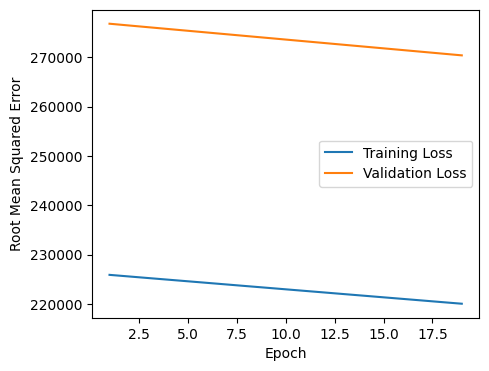

In [18]:
learning_rate = 0.5
batch_size = 100
epochs = 20
validation_split = 0.2

model = build_model(learning_rate)
w, b, epochs, history = train_model(model, train_df, feature_column, label_column, epochs, batch_size, validation_split)

plot_loss_curves(epochs=epochs, 
                 training_losses=history['root_mean_squared_error'], 
                 validation_losses=history['val_root_mean_squared_error'])

##### Comments on the result

The Loss Curves of Training Set and Validation Set are significantly different. So something wrong?

#### Fix the problem
Shuffle the Training Set

In [32]:
# shuffle the training set
shuffled_train_df = train_df.reindex(np.random.permutation(train_df.index))

Epoch 1/20
136/136 [==============================] - 1s 2ms/step - loss: 56267214848.0000 - root_mean_squared_error: 237207.1094 - val_loss: 56546996224.0000 - val_root_mean_squared_error: 237796.1250
Epoch 2/20
136/136 [==============================] - 0s 2ms/step - loss: 56108339200.0000 - root_mean_squared_error: 236871.9844 - val_loss: 56386969600.0000 - val_root_mean_squared_error: 237459.4062
Epoch 3/20
136/136 [==============================] - 0s 3ms/step - loss: 55952613376.0000 - root_mean_squared_error: 236543.0469 - val_loss: 56228528128.0000 - val_root_mean_squared_error: 237125.5469
Epoch 4/20
136/136 [==============================] - 0s 3ms/step - loss: 55795437568.0000 - root_mean_squared_error: 236210.5781 - val_loss: 56069595136.0000 - val_root_mean_squared_error: 236790.1875
Epoch 5/20
136/136 [==============================] - 1s 4ms/step - loss: 55638773760.0000 - root_mean_squared_error: 235878.7344 - val_loss: 55910772736.0000 - val_root_mean_squared_error: 23

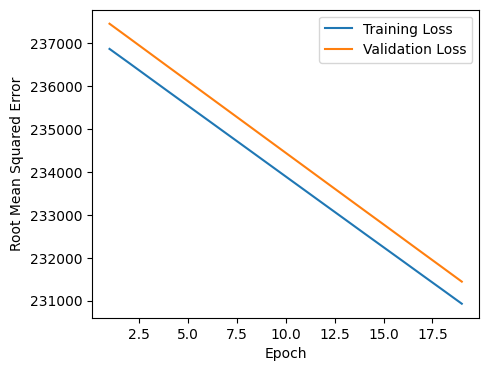

In [34]:
learning_rate = 0.5
batch_size = 100
epochs = 20
validation_split = 0.2

model=build_model(learning_rate)
weight, bias, epochs, history = train_model(model, shuffled_train_df, feature_column, label_column, epochs, batch_size, validation_split)
plot_loss_curves(epochs, history['root_mean_squared_error'], history['val_root_mean_squared_error'])

#### Test the model with Test Set

In [37]:
x_test = test_df[feature_column]
y_test = test_df[label_column]
results = model.evaluate(x=x_test, y=y_test, batch_size=batch_size)
print(results)

30/30 [==============================] - 0s 3ms/step - loss: 52145528832.0000 - root_mean_squared_error: 228353.9531
[52145528832.0, 228353.953125]
